# Geodatenanalyse 1

## Tag 1 / Block 2 / Übung 8: Grundlagen der Sensitivitätsanalyse

### Contribution-to-Variance



Als Anwendungsbeispiel für eine Sensitivitätsanalyse werden wir das Model und die Unsicherheitsanalyse aus der letzten Übung verwenden. Kopiert daher zuerst das Skript mit der MC Simulation in dieses Notebook, damit ihr alle Input- und Outputwerte als Variablen zur Verfügung habt. 

In [2]:
# Monte-Carlo Simulation zur Bestimmung der Abbaurate von O-Xylol
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

n = 5000 # number of MC simulations 

# input data 
# isotope shift delta 13C [o/oo], truncated to (3.8, 4.8)
a, b = (3.8 - 4.3) / 0.7, (4.8 - 4.3) / 0.7
deltaC = truncnorm.rvs(a, b, 4.3, 0.7, size=n)
# isotope enrichment factor epsilon [-]
epsilon = np.random.uniform(-3.2, -1.1, n)
# distance [m]
s = np.random.uniform(415, 423, n)
# effective porosity [-], trunctaed to (0.12, 0.30)
a, b = (0.12 - 0.21) / 0.9, (0.3 - 0.21) / 0.9
neff = truncnorm.rvs(a, b, 0.21, 0.9, size=n)
# time, truncated to (3e8, 3.3e8)
a, b = (3e8 - 3.15e8) / 1.6e6, (3.3e8 - 3.15e8) / 1.6e6
t = truncnorm.rvs(a, b, 3.15e8, 1.6e6, size=n)
# hydraulic gradient [-]
grad = np.random.uniform(1.3e-3, 1.6e-3, n)

kf =np.zeros(n)
lambda_rate = np.zeros(n)
# analytical model
for i in range(n):
    kf[i] = (s[i]*neff[i])/(t[i]*grad[i])
    lambda_rate[i] = -(deltaC[i]*kf[i]*grad[i])/(epsilon[i]*s[i]*neff[i])

lambda_rate = lambda_rate*3600*24*365 # to get values as [1/a]

Für die Contribution-to-Variance Analyse und die Berechnung von Kovarianzen und Korrelationen ist es praktisch, alle benötigten Werte in einem DataFrame zusammenzufassen, um sicherzustellen, dass die Dimensionen, Ausrichtung von Spalten usw. stimmen. 

Hier nochmal ein Hinweis zum pandas Syntax für das Zusammenfassen von Arrays als Spalten: data = pd.DataFrame({'column_name': column_value, ...})

Berechnet anschließend die Kovarianzen (`data.cov()`) und Korrelationen nach Pearson (`data.corr()`) für den DataFrame. Welches Maß macht in unserem Fall hier mehr Sinn für eine Betrachtung der Sensitivitäten? 

In [3]:
# [2] hier Code eingeben
import pandas as pd

data = pd.DataFrame({'lambda_rate': lambda_rate, 'kf': kf, 'deltaC': deltaC, 'epsilon': epsilon, 's':s,
                     'neff': neff, 't': t, 'grad': grad})

covariance = data.cov()
correlation = data.corr()

Stellt nun die Ergebnisse für die Sensitivitätsanalyse, sowohl für den kf-Wert als auch die Abbaurate (`subplot`), graphisch in einem Tornadoplot dar. Am einfachsten geht das über ein horizontales Blaknediagramm mit `matplotlib.pyplot.barh()`. Überlegt Euch auch genau welche Werte aus der Korrelations-, bzw- Kovarianzmatrix, enthalten sein sollten, und verwendet `labels` für die Achsenbeschriftung. 


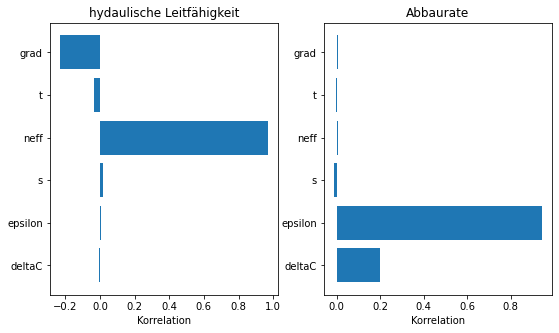

In [4]:
# [3] hier Code eingeben
import matplotlib.pyplot as plt

labels = ['deltaC', 'epsilon', 's', 'neff', 't', 'grad']
plot_bio = correlation.iloc[0,2:len(correlation)].to_numpy()
plot_kf = correlation.iloc[1,2:len(correlation)].to_numpy()

fig = plt.figure(1, figsize=(9, 5))

ax = fig.add_subplot(1,2,1)
plt.barh(labels, width=plot_kf)
plt.xlabel('Korrelation')
plt.title ('hydaulische Leitfähigkeit')

ax1 = fig.add_subplot(1,2,2)
plt.barh(labels, width=plot_bio)
plt.xlabel('Korrelation')
plt.title ('Abbaurate')
plt.show()


### Resampling 

In Python lässt sich ein Resampling-Datensatz über die Funktion `np.random.choice()` erzeugen. Als Inputs werden hier der ursprüngliche Array, die gewünschte Größe ("size") des Resamplingdatensatzes, sowie eine Angabe zu "replace" benötigt. 

"replace=True" entspricht einem Bootstrap-Resampling, "replace=False" einem Jackknife-Resampling. Entsprechend muss bei einem Jackknife-Resampling "size" kleiner als die Größe der Ausgangs-Arrays gesetzt werden.  

Erzeugt nun ein Bootstrap-Resampling des MC Inputdatensatzes für eine erneute Berechnung von kf und lambda. Geht dazu folgendermaßen vor: 

1. Originaldaten in einen gemeinsam DataFrame packen (s. Syntax oben)

2. Einen neuen leeren Datensatz für das Resampling erzeugen. Dabei müssen Anzahl und Bezeichnung des Index und der Spalten identisch zum eben definierten Ausgangsdatensatz sein. Das geht über den pandas Befehl `pd.DataFrame(index=data.index, columns=input_data.columns)`


3. Spaltenweise mit einer for-Schleife und `np.random.choice()` die Inputdaten resamplen  

In [7]:
# [4] hier Code eingeben
# original data
input_data = pd.DataFrame({'deltaC': deltaC, 'epsilon': epsilon, 's':s,
                     'neff': neff, 't': t, 'grad': grad})

# empty dataframe for new permuted input data
rand_data = pd.DataFrame(index=data.index, columns=input_data.columns)

#column-wise creation of a new permuted input data set 
for i in range(len(input_data.columns)):
    rand_data.iloc[:, i] = np.random.choice(input_data.iloc[:, i], replace=True, size = len(rand_data))

Basierend auf dem Resamlingdatensatz könnt Ihr nun erneut kf und lambda berechnen. Am besten in zwei neue Arrays (ohne die ursprünglichen zu überschreiben), damit Ihr die ursprünglichen Outputs mit denen des Resamlings vergleichen könnt. 

In [8]:
# [5] hier Code eingeben
# empty vector for new outputs kf and lambda
kf_rand =np.zeros(n)
lambda_rate_rand = np.zeros(n)

# calculate new kf and lambda
for i in range(len(rand_data)):
    kf_rand[i] = (rand_data['s'][i]*rand_data['neff'][i])/(rand_data['t'][i]*rand_data['grad'][i])
    lambda_rate_rand[i] = -(rand_data['deltaC'][i]*kf_rand[i]*rand_data['grad'][i])/(rand_data['epsilon'][i]*rand_data['s'][i]*rand_data['neff'][i])
    
lambda_rate_rand = lambda_rate_rand*3600*24*365 # to get values as [1/a]

Anschließend können nun die Resampling-Outputs mit den Resampling-Inputs vereint werden, um eine neue Korrelationsmatrix zu berechnen. Vergleicht dann die beiden Korrelationsmatrizen (z.B. graphisch). 

Hinweis: Da hier nun verschiedenen Python-Datentypen vorliegen, ist es geschickt zuerst aus den neuen Arrays mit kf und lambda einen neuen DataFrame erstellen (s. Syntax oben), und diesen dann über `pd.concat([data1, data2], axis=1)` spaltenmweise mit den Resampling-Inputs vereinen. 



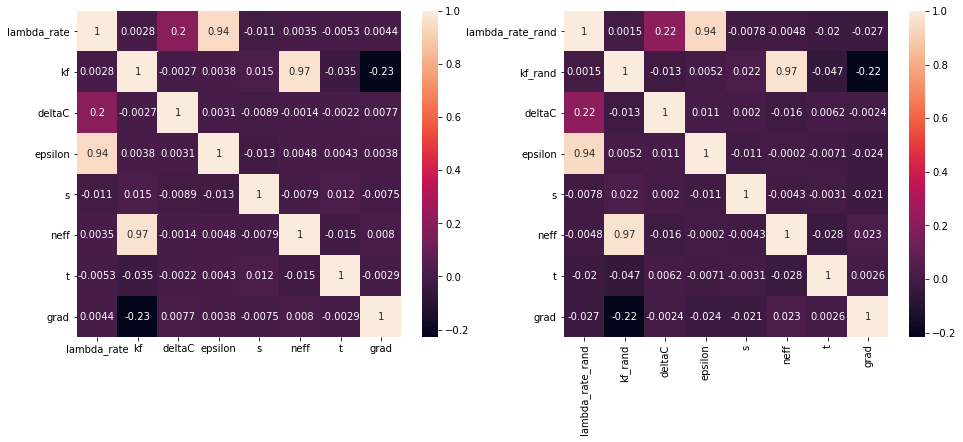

In [9]:
# [6] hier Code eingeben
# Input und Output Datensätze vereinen 

output_rand = pd.DataFrame({'lambda_rate_rand': lambda_rate_rand, 'kf_rand': kf_rand})
output_rand = pd.concat([output_rand,rand_data], axis=1)

# Korrelation berechnen
rand_corr = output_rand.corr()

# Korrelationen visualisieren 
import seaborn as sns
fig = plt.figure(1, figsize=(16, 6))

ax = fig.add_subplot(1,2,1)
sns.heatmap(correlation, annot=True)

ax1 = fig.add_subplot(1,2,2)
sns.heatmap(rand_corr, annot=True)

plt.show()

Damit ist der Workflow für genau eine weitere Auswertung der Korrelation, bzw. Sensitivität abgeschlossen. Wenn wir nun ein for-Schleife mit bspw. 500 Wiederholungen um diesen Workflow legen würden, könnten wir die Unsicherheit in der Korrelation, und damit der Sensitivität, analysieren. 

Wer möchte, kann es ja mal probieren ;)

In [ ]:
# [7] hier Code eingeben
# for Schleife für resampling 

## Ende

### Referenzen: 

Würth et al. (2021): Quantifying biodegradation rate constants of o-xylene by combining compound-specific isotope analysis and groundwater dating. Journal of Contaminant Hydrology, 238, 103757